# Intro
This is a jupyter notebook for finding distant/unrelated pairs using features generated from the full Pfam-A.hmm instead of the two hmm files used in BiG-SLICE

This code is part of the BiG-SCAPE 2.0 thesis project  

Start by importing these modules

In [1]:
import multiprocessing
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import plots.hist

import data
import truth.truth as truth
import input.paths as paths
import input.bigslice_hmm

import predictions
import predictions.tests

import validation

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from scipy import spatial

import math

The following code instantiates any relevant paths to data or output. Make sure to change these for your purposes.
Not all the paths may be relevant, e.g. if you are using the bigscape_distances.tsv that is included in this repository.

In [2]:
# location of the full bigscape distances tab separated file.
# this file is created if you are loading new values from a run using the path after this one
FULL_TSV = "bigscape_distances.tsv"

# location of the sqlite database to analyze
# this database contained generated l2 normalized features
SQLITE_DB = "D:/Temp/benchmark-out/just-features-100/data.db"


In [3]:
print("Loading truth")
# load truth values
TRUTH_DISTANCES = truth.from_file(FULL_TSV)

TRUTH_PAIRS = validation.pairs_from_distances(TRUTH_DISTANCES)

print("Loading stored info from database")
DB = data.Database(SQLITE_DB)

BGC_IDS = data.get_bgc_ids(DB)
HMM_IDS = data.get_hmm_ids(DB)

BGC_ID_NAME_DICT = data.get_bgc_id_name_dict(DB)
BGC_NAME_ID_DICT = {name: id for id, name in BGC_ID_NAME_DICT.items()}
print("Done")
print(len(BGC_IDS), "BGCs in database")

Loading truth
Loading stored info from database
Done
2982 BGCs in database


In [4]:
print("Instantiating dataframes")
# instantiate dataframes
FEATURES = pd.DataFrame(
    np.zeros((len(BGC_IDS), len(HMM_IDS)), dtype=np.uint8),
    index=BGC_IDS,
    columns=HMM_IDS
)

# fetch feature values from db
BGC_HMM_FEATURES = data.get_features(DB)
for bgc_id, hmm_id, value in BGC_HMM_FEATURES:
    FEATURES.at[bgc_id, hmm_id] = value
print("Done")

Instantiating dataframes
Done


In [5]:
FEATURES_NORM = pd.DataFrame(normalize(FEATURES, norm='l2', axis=0, copy=False, return_norm=False))

In [6]:
EUCLIDEAN_DISTS = predictions.get_distances(FEATURES_NORM, BGC_ID_NAME_DICT, metric="euclidean")

In [ ]:
print("Generating distance/index dictionary")
BIGSCAPE_EUCLIDEAN_DICT = {}
for bgc1, bgc2, dist in TRUTH_DISTANCES:
    pair_key = "-".join(sorted([bgc1, bgc2]))
    BIGSCAPE_EUCLIDEAN_DICT[pair_key] = [dist]

for bgc1, bgc2, dist in EUCLIDEAN_DISTS:
    pair_key = "-".join(sorted([bgc1, bgc2]))
    # ignore duplicates
    if (len(BIGSCAPE_EUCLIDEAN_DICT[pair_key]) == 1):
        BIGSCAPE_EUCLIDEAN_DICT[pair_key].append(dist)

x = []
y = []
l = []
for i, item in BIGSCAPE_EUCLIDEAN_DICT.items():
    dist, idx = item
    x.append(dist)
    y.append(idx)
    if dist < 0.3:
        l.append("#037bfc")
    else:
        l.append("#fc9d03")

plt.scatter(x, y, c=l)

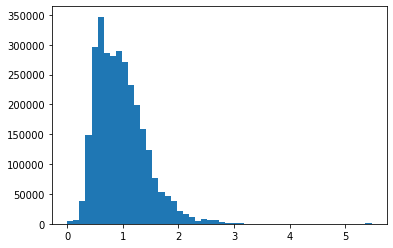

In [7]:
plots.hist.from_distances(EUCLIDEAN_DISTS, max=None, bins=50)

In [12]:
predictions.tests.distance.run_upper(
    EUCLIDEAN_DISTS,
    TRUTH_PAIRS,
    upper_range=10,
    upper_cutoff_step=0.1,
    upper_cutoff_start=0.5
)

Predictions from distances (upper only):
cut_upp,under,over,unclass,prec,sens,spec,acc,ppv,npv,tp,fp,tn,fn
0.1,0,2474797,2091,NA,0.0,1.0,0.996,NA,0.996,0,0,754272,2707
0.2,0,2471891,4997,NA,0.0,1.0,0.996,NA,0.996,0,0,753354,2701
0.3,0,2461433,15455,NA,0.0,1.0,0.996,NA,0.996,0,0,750133,2692
0.4,0,2410830,66058,NA,0.0,1.0,0.996,NA,0.996,0,0,733913,2629
0.5,0,2300219,176669,NA,0.0,1.0,0.996,NA,0.996,0,0,699073,2503
0.6,0,2147283,329605,NA,0.0,1.0,0.996,NA,0.996,0,0,651794,2296
0.7,0,1973951,502937,NA,0.0,1.0,0.997,NA,0.997,0,0,598765,2066
0.8,0,1763864,713024,NA,0.0,1.0,0.997,NA,0.997,0,0,535987,1829
0.9,0,1504175,972713,NA,0.0,1.0,0.997,NA,0.997,0,0,457663,1526
1.0,0,1241378,1235510,NA,0.0,1.0,0.997,NA,0.997,0,0,379170,1262
1.1,0,996783,1480105,NA,0.0,1.0,0.997,NA,0.997,0,0,305111,1026
1.2,0,783753,1693135,NA,0.0,1.0,0.997,NA,0.997,0,0,239110,789
1.3,0,601326,1875562,NA,0.0,1.0,0.997,NA,0.997,0,0,184727,579
1.4,0,449709,2027179,NA,0.0,1.0,0.997,NA,0.997,0,0,136903,398
1.5,0,327835,214905

In [17]:
predictions.tests.distance.run_lower(
    EUCLIDEAN_DISTS,
    TRUTH_PAIRS,
    lower_range=11,
    lower_cutoff_step=0.1,
    lower_cutoff_start=0.5,
    invert=True
)

Predictions from distances (lower only):
cut_low,under,over,unclass,prec,sens,spec,acc,ppv,npv,tp,fp,tn,fn
0.5,0,176669,2300219,NA,0.0,1.0,0.996,NA,0.996,0,0,55820,207
0.6,0,329605,2147283,NA,0.0,1.0,0.996,NA,0.996,0,0,103099,414
0.7,0,502937,1973951,NA,0.0,1.0,0.996,NA,0.996,0,0,156128,644
0.8,0,713024,1763864,NA,0.0,1.0,0.996,NA,0.996,0,0,218906,881
0.9,0,972713,1504175,NA,0.0,1.0,0.996,NA,0.996,0,0,297230,1184
1.0,0,1235510,1241378,NA,0.0,1.0,0.996,NA,0.996,0,0,375723,1448
1.1,0,1480105,996783,NA,0.0,1.0,0.996,NA,0.996,0,0,449782,1684
1.2,0,1693135,783753,NA,0.0,1.0,0.996,NA,0.996,0,0,515783,1921
1.3,0,1875562,601326,NA,0.0,1.0,0.996,NA,0.996,0,0,570166,2131
1.4,0,2027179,449709,NA,0.0,1.0,0.996,NA,0.996,0,0,617990,2312


In [32]:
COSINE_DIST_CORR = predictions.get_corr_cosine_dists(
    TRUTH_DISTANCES,
    BGC_HMM_FEATURES,
    BGC_IDS,
    BGC_NAME_ID_DICT
)

10.0% done
20.0% done
30.0% done
40.0% done
50.0% done
60.0% done
70.0% done
80.0% done
90.0% done
100.0% done


In [ ]:
print("Generating distance/index dictionary")
BIGSCAPE_CORR_DICT = {}
for bgc1, bgc2, dist in TRUTH_DISTANCES:
    pair_key = "-".join(sorted([bgc1, bgc2]))
    BIGSCAPE_CORR_DICT[pair_key] = [dist]

for bgc1, bgc2, dist in COSINE_DIST_CORR:
    pair_key = "-".join(sorted([bgc1, bgc2]))
    # ignore duplicates
    if (len(BIGSCAPE_CORR_DICT[pair_key]) == 1):
        BIGSCAPE_CORR_DICT[pair_key].append(dist)

x = []
y = []
l = []
for i, item in BIGSCAPE_CORR_DICT.items():
    dist, idx = item
    x.append(dist)
    y.append(idx)
    if dist < 0.3:
        l.append("#037bfc")
    else:
        l.append("#fc9d03")

plt.scatter(x, y, c=l)

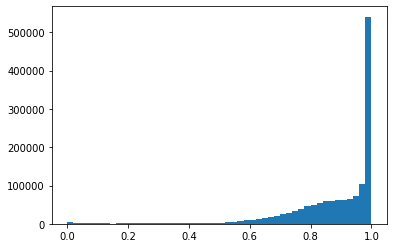

In [33]:
plots.hist.from_distances(COSINE_DIST_CORR, max=None, bins=50)

In [34]:
predictions.tests.distance.run_upper(
    COSINE_DIST_CORR,
    TRUTH_PAIRS,
    upper_range=9,
    upper_cutoff_step=0.1,
    upper_cutoff_start=0.2
)

Predictions from distances (upper only):
cut_upp,under,over,unclass,prec,sens,spec,acc,ppv,npv,tp,fp,tn,fn
0.2,0,1333716,13931,NA,0.0,1.0,1.0,NA,1.0,0,0,1333210,520
0.3,0,1327182,20465,NA,0.0,1.0,1.0,NA,1.0,0,0,1326938,256
0.4,0,1321803,25844,NA,0.0,1.0,1.0,NA,1.0,0,0,1321675,135
0.5,0,1314326,33321,NA,0.0,1.0,1.0,NA,1.0,0,0,1314248,80
0.6,0,1292835,54812,NA,0.0,1.0,1.0,NA,1.0,0,0,1292778,57
0.7,0,1227254,120393,NA,0.0,1.0,1.0,NA,1.0,0,0,1227249,5
0.8,0,1083954,263693,NA,NA,1.0,1.0,NA,1.0,0,0,1083954,0
0.9,0,829829,517818,NA,NA,1.0,1.0,NA,1.0,0,0,829829,0
1.0,0,393190,954457,NA,NA,1.0,1.0,NA,1.0,0,0,393190,0
